# Defining and Visualizing fmdtools Model Structures

To ensure that a simulation meets the intent of a modeller, it is important to carefully define the structure of the model and run order. This notebook will demonstrate fmdtools' interfaces both for setting up model structures and for fault visualization.

NOTE: For some of these visualizations to display properly without re-running code use, `File -> Trust Notebook`.

In [1]:
from fmdtools.define.model import Model
from fmdtools.define.block import FxnBlock, Component
import fmdtools.analyze as an
import fmdtools.sim.propagate as prop

## Basics

An fmdtools model is made up of functions--model structures with behavioral methods and internal states--and flows--data relationships between functions. These functions and flows are defined in python classes and thus may be instantiated multiple times in a model to create multi-component models with complex interactions. The structure of these model classes is shown below:

![Model Classes](files/figures/example_model.png)

Creating a model thus involves:
- defining the function and flow classes defining the behavior of the model in the model module
- defining the specific structure for the model: function and flow *objects* (instantiations of functions) and their relationships.

Model structure visualization is performed in the `an.graph.ModelGraph` class and its sub-classes. 

In [2]:
help(an.graph.ModelGraph)

Help on class ModelGraph in module fmdtools.analyze.graph:

class ModelGraph(Graph)
 |  ModelGraph(mdl, get_states=True, time=0.0, **kwargs)
 |  
 |  Creates a Graph of Model functions and flow for display, where both functions
 |  and flows are nodes.
 |  
 |  If get_states option is used on instantiation, a `states` dict is associated
 |  with the edges/nodes which can then be used to visualize function/flow attributes.
 |  
 |  Method resolution order:
 |      ModelGraph
 |      Graph
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mdl, get_states=True, time=0.0, **kwargs)
 |      Generates the ModelGraph corresponding to a given Model
 |      
 |      Parameters
 |      ----------
 |      mdl : define.Model
 |          fmdtools model to represent graphically
 |      get_states : bool, optional
 |          Whether to copy states to the node/edge 'states' property.
 |          The default is True.
 |      time: float
 |          Time model is run at (to

The main function used for displaying model structure is `draw()`

In [3]:
help(an.graph.ModelGraph.draw)

Help on function draw in module fmdtools.analyze.graph:

draw(self, figsize=(12, 10), title='', fig=False, ax=False, withlegend=True, legend_bbox=(1, 0.5), legend_loc='center left', legend_labelspacing=2, legend_borderpad=1, **kwargs)
    Draws a networkx graph g with given styles corresponding to the node/edge
    properties.
    
    Parameters
    ----------
    figsize : tuple, optional
        Size for the figure (plt.figure arg). The default is (12,10).
    title : str, optional
        Title for the plot. The default is "".
    fig : bool, optional
        matplotlib figure to project on (if provided). The default is False.
    ax : bool, optional
        matplotlib axis to plot on (if provided). The default is False.
    withlegend : bool, optional
        Whether to include a legend. The default is True.
    legend_bbox : tuple, optional
        bbox to anchor the legend to. The default is (1,0.5) (places legend on the
                                                          

However, these relationships only define the *structure* of the model--for the model to simulate correctly and efficiently, the run order of fuctions additionally must be defined.

Each timestep of a model simulation can be broken down into two steps: 

![Dynamic Propagation Step](figures/dynamic_step.png) 

- **Dynamic Propagation Step:** In the dynamic propagation step, the time-based behaviors (e.g. accumulations, movement, etc.) are each run *once* in a specified order. These steps are generally quicker to execute because each behavior is only run once and the flows do not need to be tracked to determine which behaviors to execute next. This step is run first at each time-step of the model.

![Static Propagation Step](figures/propagation.PNG)

- **Static Propagation Step:**
    In the static propagation step, behaviors are propagated between functions iteratively until the state of the model converges to a single value. This may require an update of multiple function behaviors until there are no more new behaviors to run. Thus, static behaviors should be ''timeless'' (always give the same output for the same input) and convergent (behaviors in each function should not change each other ad infinitum). This step is run second at each time-step of the model.

With these different behaviors, one can express a range of different types of models:
- **static models** where only only one timestep is run, where fault scenarios show the immediate propagation of faults through the system.
- **dynamic models** where a number of timesteps are run (but behaviors are only run once).
- **hybrid models** where dynamic behaviors are run once and then a static propagation step is performed at each time-step.

The main interfaces/functions involved in defining run order are:
- `FxnBlock.static_behavior(self, time)` and `FxnBlock.behavior(self, time)`, which define function behaviors which occur during the static propagation step. 
- `FxnBlock.dynamic_behavior(self, time)`, which defines function behaviors during the dynamic propagation step.
- `FxnBlock.condfaults(self, time)`, does not define run order, but it can be used for behaviors which would at any time during simulation (dynamic or static) lead to the system entering a fault mode (e.g., conditional faults).
- `Model.add_fxn()`, which when used successively for each function specifies that those functions run in the order they are added.

There is additionally `Model.build()`, which enables one to manually specify the order of the dynamic propagation step (and initial static step):

In [4]:
help(Model.build)

Help on function build in module fmdtools.define.model:

build(self, functionorder=[], require_connections=True)
    Builds the model graph after the functions have been added.
    
    Parameters
    ----------
    functionorder : list, optional
        The order for the functions to be executed in. The default is [].



The overall static/dynamic propagation steps of the model can then be visualized using `ModelGraph.set_exec_order` successively with `ModelGraph.draw()`.

In [5]:
help(an.graph.ModelGraph.set_exec_order)

Help on function set_exec_order in module fmdtools.analyze.graph:

set_exec_order(self, mdl, static={}, dynamic={}, next_edges={}, label_order=True, label_tstep=True)
    Enables the plotting of ModelGraph execution order.
    
    Parameters
    ----------
    mdl : Model
        Model to plot the execution order of.
    static : dict/False, optional
        kwargs to overwrite the default style for functions/flows in the static
        execution step.
        If False, static functions are not differentiated. The default is {}.
    dynamic : dict/False, optional
        kwargs to overwrite the default style for functions/flows in the dynamic
        execution step.
        If False, dynamic functions are not differentiated. The default is {}.
    next_edges : dict
        kwargs to overwrite the default style for edges indicating the flow order.
        If False, these edges are not added. the default is {}.
    label_order : bool, optional
        Whether to label execution order (w

The next sections will demonstrate these functions using a simple hybrid model.

## Model Setup

Consider the following (highly simplified) rover electrical/navigation model. We can define the functions of this rover using the classes:

In [6]:
from fmdtools.define.state import State
from fmdtools.define.flow import Flow
from fmdtools.define.mode import Mode
class ControlState(State):
    power: float=0.0
    vel:   float=0.0
class Control(Flow):
    _init_s = ControlState
class ControlRoverMode(Mode):
    faultparams={'no_con':(1e-4, 200)}
    opermodes = ('drive', 'standby')
    mode : str='standby'

class ControlRover(FxnBlock):
    _init_m = ControlRoverMode
    _init_control = Control
    def dynamic_behavior(self,time):
        if not self.m.in_mode('no_con'):
            if time == 5:  self.m.set_mode('drive')
            if time == 50: self.m.set_mode('standby')
        if self.m.in_mode('drive'):
            self.control.s.power = 1.0
            self.control.s.vel = 1.0
        elif self.m.in_mode('standby'):
            self.control.s.vel = 0.0
            self.control.s.power=0.0

This function uses `dynamic_behavior()` to define the dynamic behavior of going through different modes depending on what model time it is. While this could also be entered in as a static behavior, because none of the defined behaviors themselves result from external inputs, there is no reason to.

In [7]:
class EEState(State):
    v:  float=0.0
    a:  float=0.0
class EE(Flow):
    _init_s = EEState
class GroundState(State):
    x:  float=0.0
class Ground(Flow):
    _init_s = GroundState

class MoveRoverMode(Mode):
    faultparams={"mech_loss":1.0, "short":1.0, "elec_open":1.0}
class MoveRoverState(State):
    power: float=0.0

class MoveRover(FxnBlock):
    _init_s = MoveRoverState
    _init_m = MoveRoverMode
    _init_ee = EE
    _init_control = Control
    _init_ground = Ground
    def static_behavior(self, time):
        self.s.power = self.ee.s.v * self.control.s.vel *self.m.no_fault("elec_open")
        self.ee.s.a = self.s.power/(12*(self.m.no_fault('short')+0.001))
        if self.s.power >100: self.m.add_fault("elec_open")
    def dynamic_behavior(self, time):
        if not self.m.has_fault("elec_open", "mech_loss"): 
            self.ground.s.x = self.ground.s.x + self.s.power*self.m.no_fault("mech_loss")

The `Move_Rover` function uses both:
- a static behavior which defines the input/output of electrical power at each instant, and
- a dynamic behavior which defines the movement of the rover over time

In this instance, the static behavior is important for enabling faults to propagate instantaneously in a single time-step (in this case, a short causing high current load to the battery). 

In [8]:
from fmdtools.define.time import Time

class StoreEnergyState(State):
    charge: float=100.0
class StoreEnergyTime(Time):
    local_dt = 0.5
class StoreEnergyMode(Mode):
    faultparams = {"no_charge":(1e-5, {'standby':1.0}, 100),
                   "short":(1e-5, {'supply':1.0}, 100)}
    opermodes = ("supply","charge","standby")
    exclusive = True
    key_phases_by = "self"
    mode: str = "standby"
    
class StoreEnergy(FxnBlock):
    _init_s = StoreEnergyState
    _init_t = StoreEnergyTime
    _init_m = StoreEnergyMode
    _init_ee = EE
    _init_control = Control
    def static_behavior(self,time):
        if self.ee.s.a > 5: self.m.add_fault("no_charge")
    def dynamic_behavior(self,time):
        if self.m.in_mode("standby"):     
            self.ee.s.put(v = 0.0, a=0.0)
            if self.control.s.power==1: self.m.set_mode("supply")
        elif self.m.in_mode("charge"):    
            self.s.charge =min(self.s.charge+self.t.dt, 20.0)
        elif self.m.in_mode("supply"):
            if self.s.charge > 0:         
                self.ee.s.v = 12.0
                self.s.charge -= self.t.dt
            else: self.m.set_mode("no_charge")
            if self.control.s.power==0: 
                self.m.set_mode("standby")
        elif self.m.in_mode("short"):     
            self.ee.s.v = 100.0
            self.s.charge = 0.0
        elif self.m.in_mode("no_charge"): 
            self.ee.s.v=0.0 
            self.s.charge = 0.0

The `Store_Energy` function has both a static behavior and a dynamic behavior. In this case, the static behavior enables the propagation of an adverse current from the drive system to damage the battery instantaneously, (instead of over several timesteps).

We've also set a *local timestep* dt=0.5, which simulates the 'dynamic_behavior' twice as often as fxngraph. This could be used to enable higher-grained behaviors for dt<tstep or lower simulation costs for dt>tstep--in this case, the expected behaviors are not expected to change.

In [9]:
class ForceState(State):
    transfer:  float=1.0
    magnitude: float=1.0
class Force(Flow):
    _init_s = ForceState
class VideoState(State):
    line:  float=0.0
    angle: float=0.0
class Video(Flow):
    _init_s = VideoState
        
class Rover(Model):
    default_sp = {'times':(0,60), 'phases':(('start',1,30), ('end',31, 60))}
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.add_flow('ground', Ground)
        self.add_flow('force', Force)
        self.add_flow('ee', EE)
        self.add_flow('video', Video)
        self.add_flow('control', Control)
        self.add_flow('comms', Flow) #{'x':0,'y':0}
        
        self.add_fxn("control_rover", ControlRover, "video","comms", "ee", "control","force")
        self.add_fxn("store_energy", StoreEnergy,  "ee", "force", "control")
        self.add_fxn("move_rover", MoveRover, "ground","force","ee", "control")
        self.add_fxn("view_ground", FxnBlock, "ground", "ee", "video","force")
        self.add_fxn("communicate", FxnBlock, "comms", "ee","force")
        self.build()
rover_pos = {'control_rover': [-0.017014983401385075, 0.8197778602536954],
 'move_rover': [0.1943738434915952, -0.5118219332727401],
 'store_energy': [-0.256309000069049, -0.004117688709924516],
 'view_ground': [-0.7869889764273651, 0.47147713497270827],
 'communicate': [0.5107674237596388, 0.4117119127760298],
 'ground': [-0.7803536309752367, -0.4502200140852195],
 'force': [0.4327741966569625, 0.13966361395868865],
 'ee': [-0.6981138376424448, 0.13829658866345518],
 'video': [-0.49486453723245205, 0.698244546263499],
 'control': [0.11615283552311584, -0.1842023746850714],
 'comms': [0.3373143873188402, 0.6507526319915691]}
        

### Graph Visualization

Without defining anything about the simulation itself, the containment relationships between the model structures can be visualized using `ModelGraph`, `ModelFlowGraph`, `ModelFxnGraph`, and `ModelTypeGraph`.

In [10]:
from fmdtools.analyze.graph import ModelGraph, ModelFlowGraph, ModelFxnGraph, ModelTypeGraph

c:\users\dhulse\documents\github\fmdtools\fmdtools\define\block.py:68: UserWarning: these flows sent from model ['video', 'comms', 'ee', 'force'] not added to class <class '__main__.ControlRover'>
  warnings.warn("these flows sent from model "+str([*flows.keys()])+" not added to class "+str(obj.__class__))
c:\users\dhulse\documents\github\fmdtools\fmdtools\define\block.py:68: UserWarning: these flows sent from model ['force'] not added to class <class '__main__.StoreEnergy'>
  warnings.warn("these flows sent from model "+str([*flows.keys()])+" not added to class "+str(obj.__class__))
c:\users\dhulse\documents\github\fmdtools\fmdtools\define\block.py:68: UserWarning: these flows sent from model ['force'] not added to class <class '__main__.MoveRover'>
  warnings.warn("these flows sent from model "+str([*flows.keys()])+" not added to class "+str(obj.__class__))
c:\users\dhulse\documents\github\fmdtools\fmdtools\define\block.py:68: UserWarning: these flows sent from model ['ground', 'ee',

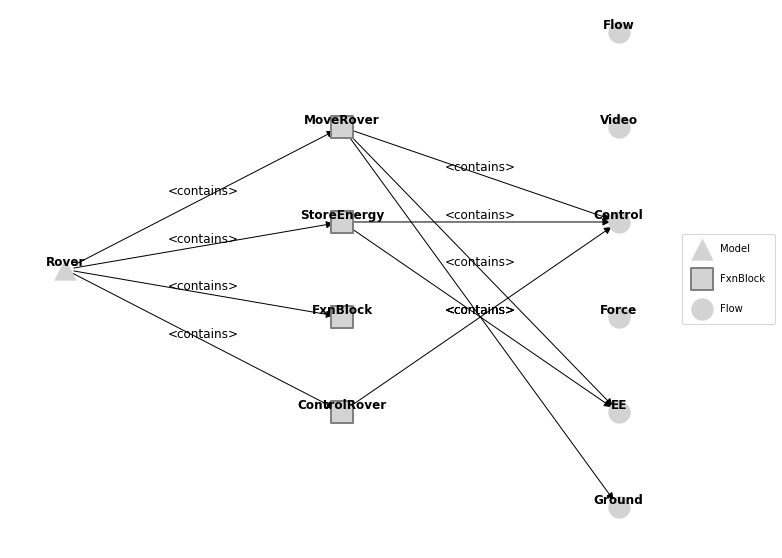

In [11]:
mdl = Rover()
mtg = ModelTypeGraph(mdl)
fig, ax = mtg.draw()

As shown, because the class for `view ground` and `communicate` are undefined, they are shown here as both instantiations of the `FxnBlock` class, which does not simulate. Additionally, `Force`, `Ground`, `Video` and `Flow` (used for comms) are left dangling since they aren't actually connected to anything.


This same structure can also be visualized using the `graphviz` and `pyviz` renderers, as shown below.

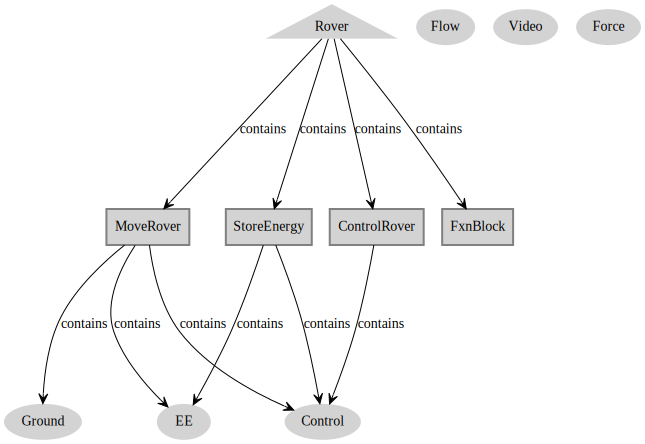

In [12]:
dot = mtg.draw_graphviz()

In [13]:
n = mtg.draw_pyvis(filename="typegraph", notebook=True)
n.show("typegraph.html")

By default, `draw` uses `matplotlib` via `networkx`'s built-in plotting functions Other renderers are considered experimental and may not support every interface style argument without bugs.

However, `graphviz` is much more fully-featured and often creates nicer-looking plots. The reason it is not used by default (and why `Graph` was not build around it) is that `graphviz` needs to be installed externally. 

The `pyviz` renderer is even more experimental and `draw_pyviz` only works for looking at model structures and has no function/fault visualization capabilities implemented. However, it produces nice interactive html views which can be quickly modified. 

## Graph Views

While the `ModelTypeGraph` view shows the containtment relationships of the *classes*, the *structural* relationships between the model functions and flows can be viewed using the `ModelFxnGraph`, `ModelFlowGraph` and `ModelGraph` classes, shown below.

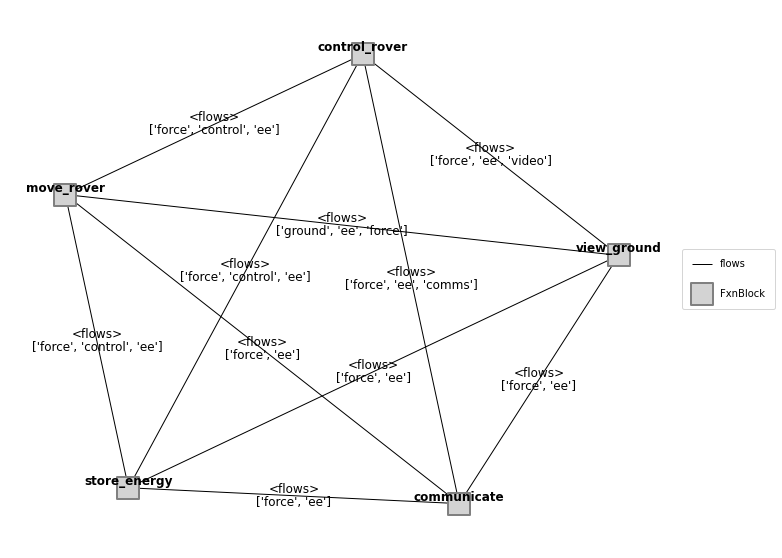

In [14]:
mfg = ModelFxnGraph(mdl)
fig, ax = mfg.draw()

Note the limitations with this representation. Specifically, flows mapped onto edges may duplicated each other (notice, for example, how many edges are listed with the `ee` flow! This 
- makes it difficult to visualize how multiple nodes are connected through the same flow 
- makes it difficult to label edges (since each edge may have a number of flows on it)
- leads to many edge overlaps

The `ModelFlowGraph` is similarly limited:

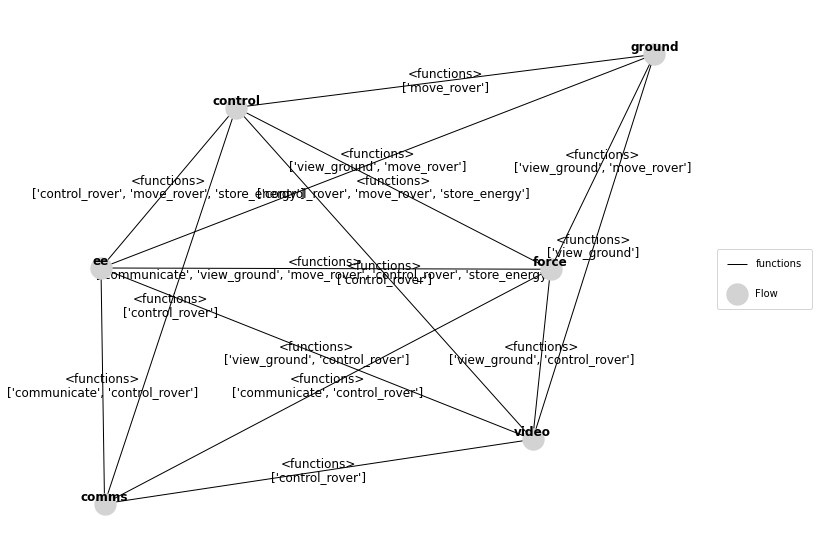

In [15]:
mfg = ModelFlowGraph(mdl)
fig, ax = mfg.draw()

As a result, we usually use the standard `ModelGraph` class, which captures the full bipartite structure of models--where both functions and flows are nodes in the graph. 

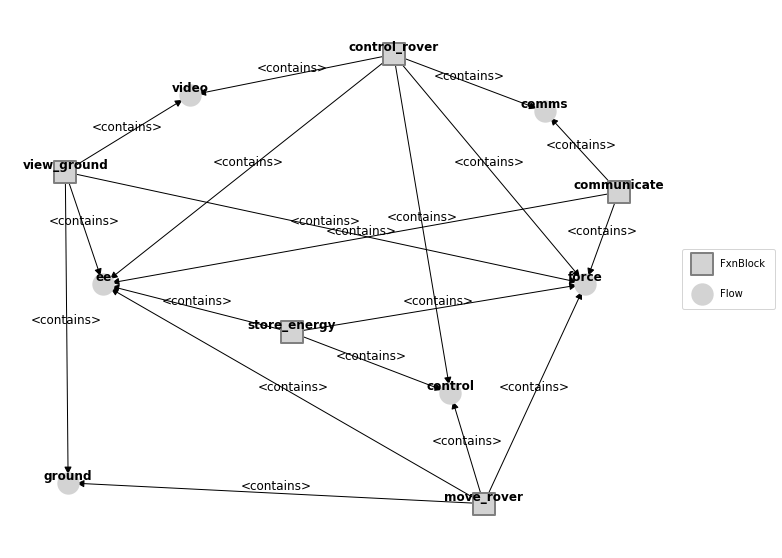

In [16]:
mg = ModelGraph(mdl)
mg.set_pos(**rover_pos)
fig, ax = mg.draw()

Note that these types are also compatible with pyviz/graphviz. Graphviz output can be customized using options for the renderer (see http://www.graphviz.org/doc/info/attrs.html for all options)

For example:

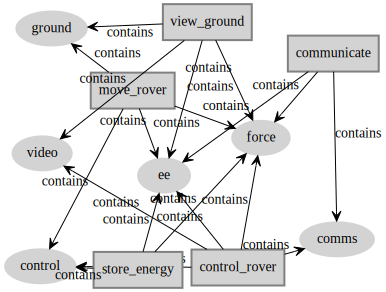

In [17]:
dot = mg.draw_graphviz(layout='neato', overlap="voronoi")

Note: the pyviz renderer does not support the "fxngraph" graph view

In [18]:
n = mg.draw_pyvis(filename="modelgraph", notebook=True)

when using the nodebook option, use show:

In [19]:
n.show("modelgraph.html")

## Run Order
To specify the run order of this model, the `add_fxn` method is used. The order of the call defines the run order of each instantiated function (`Control_Rover` -> `Move_Rover` -> `Store_Energy` ->  `View_Ground` -> `Communicate_Externally`).

In addition to the functions which have been defined here, this model additionally has a number of functions which have not been defined (and will thus not execute). We can overlay these execution characteristics onto the graph using `ModelGraph.set_exec_order`.

In [20]:
help(ModelGraph.set_exec_order)

Help on function set_exec_order in module fmdtools.analyze.graph:

set_exec_order(self, mdl, static={}, dynamic={}, next_edges={}, label_order=True, label_tstep=True)
    Enables the plotting of ModelGraph execution order.
    
    Parameters
    ----------
    mdl : Model
        Model to plot the execution order of.
    static : dict/False, optional
        kwargs to overwrite the default style for functions/flows in the static
        execution step.
        If False, static functions are not differentiated. The default is {}.
    dynamic : dict/False, optional
        kwargs to overwrite the default style for functions/flows in the dynamic
        execution step.
        If False, dynamic functions are not differentiated. The default is {}.
    next_edges : dict
        kwargs to overwrite the default style for edges indicating the flow order.
        If False, these edges are not added. the default is {}.
    label_order : bool, optional
        Whether to label execution order (w

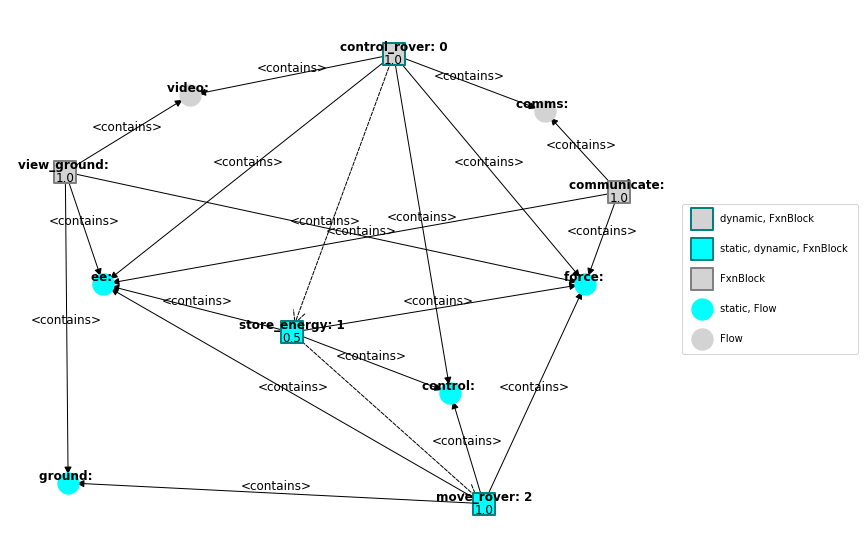

In [21]:
mg.set_exec_order(mdl)
fig, ax = mg.draw()

As shown, functions and flows active in the static propagation step are highlighted in cyan while the functions in the dynamic propagation step are shown (or given a border) in teal. Functions without behaviors are shown in light grey, and the run order of the dynamic propagation step is shown as numbers under the corresponding functions.

Additionally, by default the local timestep `dt` is labelled so we can see if/how it deviates from the overall model timestep--see, for example, the `Store_Energy` function.

In addition, `an.plot.dyn_order` can be used to visualize the dynamic propagation step.

(<Figure size 432x288 with 1 Axes>, <Axes: >)

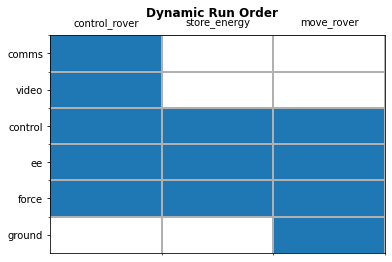

In [22]:
an.plot.dyn_order(mdl)

This plot shows that the dynamic execution step runs in the order defined in the `Model` module: first, Control_Rover, then, Store_Energy, and finally Move_Rover (reading left-to-right in the upper axis). The plot additionally shows which flows correspond to these function as it progresses through execution, which enables some understanding of which data structures are used or acted on at each execution time. 

## Behavior/Fault Visualization

To verify the static propagation of the `short` mode in the `move_rover` function, we can view the results of that scenario. As was set up, the intention of using the static propagation step was to enable the resulting fault behavior (a spike in current followed by a loss of charge) to occur in a single timestep.

In general, one can plot the effects of faults over time, using methods in `plot`, as shown below.

In [23]:
result, mdlhist = prop.one_fault(mdl, "move_rover", "short", 10, desired_result='graph')

In [24]:
result.graph

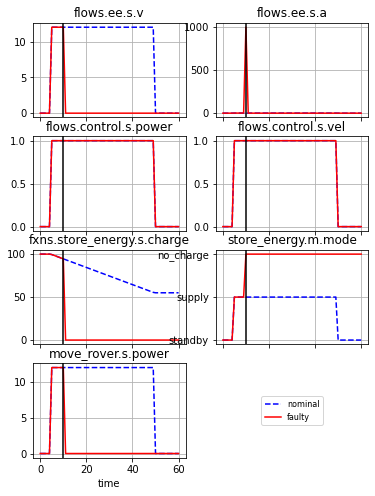

In [25]:
fig, axs = an.plot.hist(mdlhist, 
                        'flows.ee.s.v', 
                        'flows.ee.s.a', 
                        'flows.control.s.power',
                        'flows.control.s.vel',
                        'fxns.store_energy.s.charge', 
                        'store_energy.m.mode',
                        'move_rover.s.power', time_slice=10)

As shown, the static propagation step enables the mode to propagate back to the `store_energy` function (causing the `no_charge` fault) in the same timestep it is injected, even though it occurs later in the propagation order. 

However, because the voltage and current output behaviors for the function are defined in the `dynamic_behavior` method of the `store_energy` function, these are only updated to their final value (of zero) at the next step. While this enables some visualization of the current spike, it may keep faults and behaviors from further propagating through the functions as desired. Thus, to enable this, one might reallocate some of the behaviors from the `dynamic_behavior` method to the `static_behavior` method.

### Visualizing time-slices

Contained in the `result` output in `propagate.one_fault` is the `graph` specified in `desired_result`, which is a graph (multiple types may be provided). When output from `propagate` the Resgraph is by default given state information for each function/flow, as well as `degraded` and `faulty` properties which correlate with whether the `State` values deviate from those in the nominal.

Note that by default there are three main classifications for functions/flows visualized in this type of plot:
- red: faulty function. Notes that the function is in a fault mode
- orange: degraded function/flow. Nodes that the values of the flow or states of the function are *different* from the nominal scenario. Note that this is different than saying the values represent a problem, since contingency actions are also different between the nominal and faulty runs.
- grey: nominal function/flow. This notes that there is nothing different between the nominal and faulty run in that function or flow. 

These styles may be changed at will.

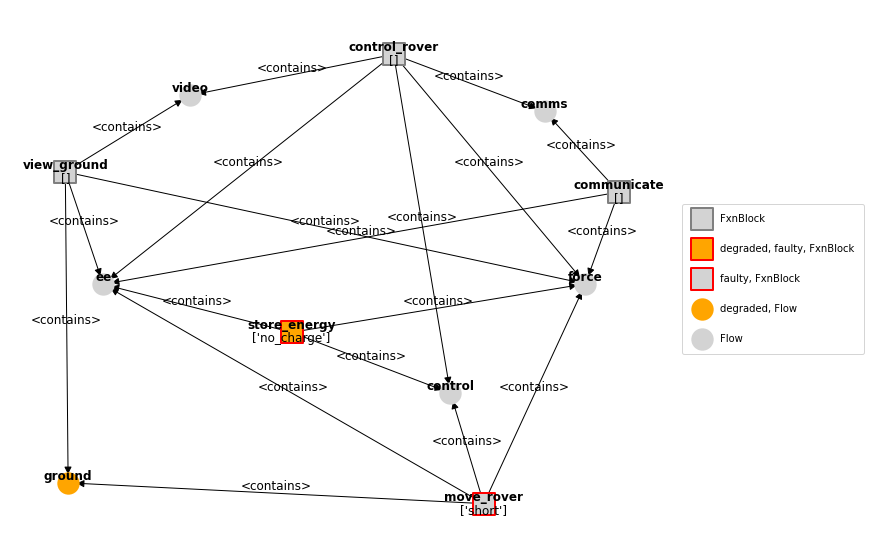

In [26]:
result.graph.set_pos(**rover_pos)
fig, ax = result.graph.draw()

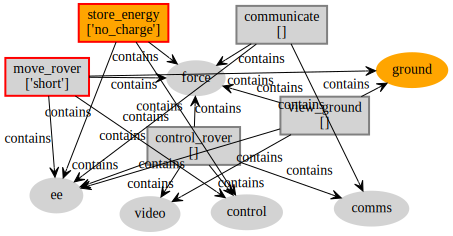

In [27]:
dot = result.graph.draw_graphviz()

The `resgraph` only gives the state of the model at the final state. We might instead want to visualize the graph at different given times. This is performed with `Graph.draw_from`:

In [28]:
help(ModelGraph.draw_from)

Help on function draw_from in module fmdtools.analyze.graph:

draw_from(self, time, history=, **kwargs)
    Draws the graph with degraded/fault data at a given time.
    
    Parameters
    ----------
    time : int
        Time to draw the graph (in the history)
    history : History, optional
        History with nominal and faulty history. The default is History().
    **kwargs : **kwargs
        arguments for Graph.draw
    
    Returns
    -------
    fig : matplotlib figure
        matplotlib figure to draw
    ax : matplotlib axis
        Ax in the figure



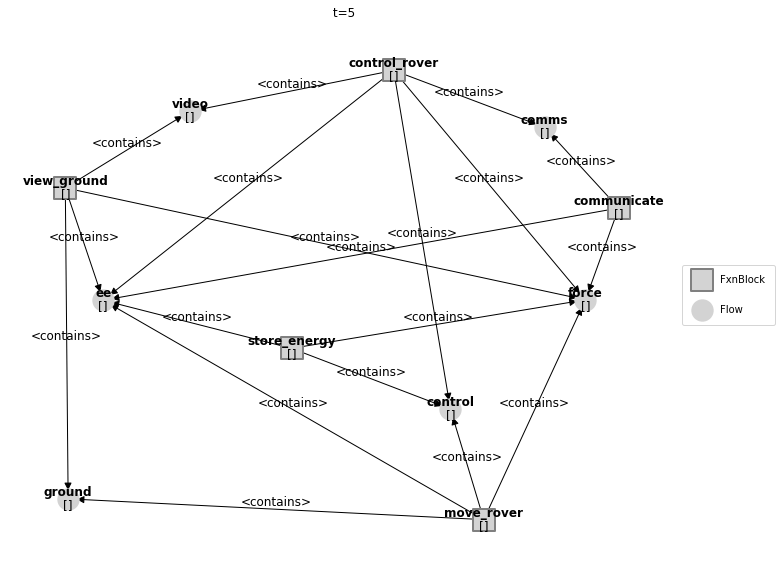

In [29]:
rmg = ModelGraph(mdl)
rmg.set_pos(**rover_pos)
fig, ax = rmg.draw_from(5, mdlhist)

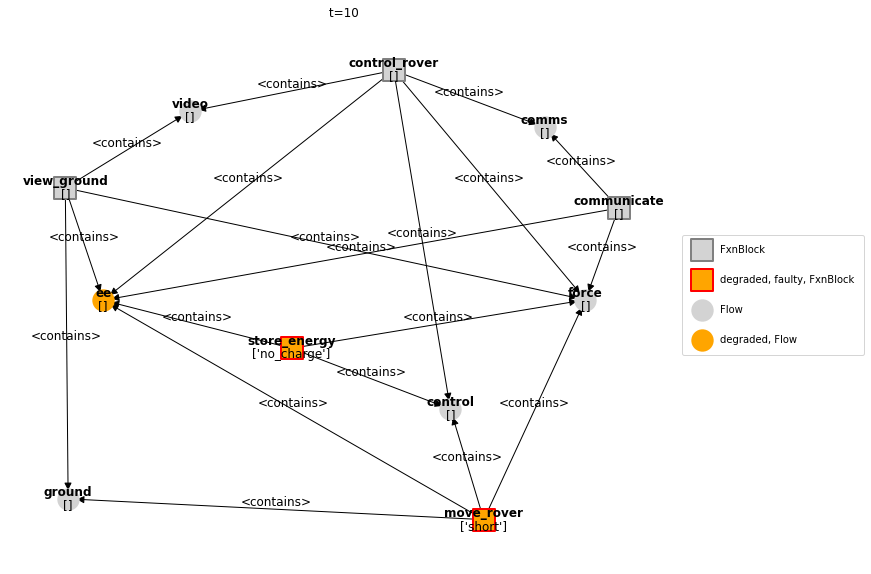

In [30]:
fig, ax = rmg.draw_from(10, mdlhist)

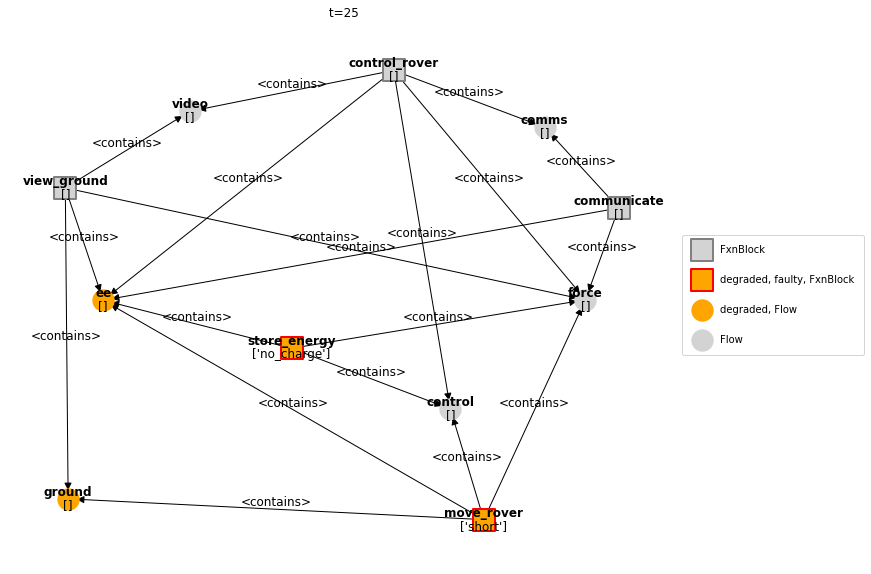

In [31]:
fig, ax = rmg.draw_from(25, mdlhist)

This can can be done automatically over a number of different times using `Graph.animate_from`:

In [32]:
help(ModelGraph.animate_from)

Help on function animate_from in module fmdtools.analyze.graph:

animate_from(self, history, times='all', figsize=(6, 4), **kwargs)
    Successively animates a plot using Graph.draw_from
    
    Parameters
    ----------
    history : History
        History with faulty and nominal states
    times : list, optional
        List of times to animate over. The default is 'all'.
    figsize : tuple, optional
        Size for the figure. The default is (6,4).
    **kwargs : kwargs
    
    Returns
    -------
    ani : matplotlib.animation.FuncAnimation
        Animation object with the given frames



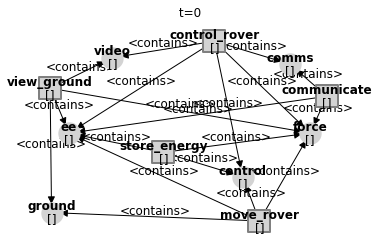

In [33]:
ani = rmg.animate_from(mdlhist)

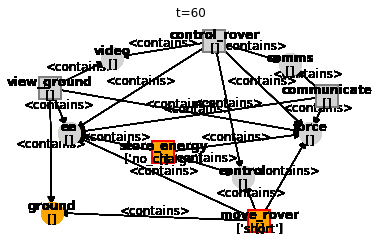

In [34]:
from IPython.display import HTML
HTML(ani.to_jshtml())